<a href="https://colab.research.google.com/github/marriamaslova/ML_homeworks/blob/main/ml_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Business Understanding**

Производится работа над прозаическими текстами фольклорного архива. Для того, чтобы тексты поместить в корпус фольклорных текстов, нужно их сопроводить рядом метатекстовых характеристик. И если, например, время и место сбора идут в комплекте с самим текстом, то про тематическую классификацию, которую также хотят видеть потенциальные пользователи корпуса, так сказать нельзя.

Значит, есть 2 пути. Первый - ручная разметка. Для ручной разметки была разработана пока что тестовая и очень простая система тегов, основанная на ключевых словах, выделенных программой анализа текстов. Всего 4 тега: Труд, География, Персоналии, Религия. Они отражают тематическую картину несказочной прозы Среднего Урала. Вариант с ручной разметкой дает гарантированное качество, но потребует человеческих ресурсов и времени.

Второй путь - попробовать автоматизировать этот процесс. Однако хороший результат не гарантирован, поскольку внутрення взаимосвязь тем в текстах, которые вручную будут размечены разными тегами, куда сильнее, чем если бы мы делили тексты про медицину, IT и кулинарию. В одном тексте могут встретиться ключевые слова разных групп, но экспертная оценка позволяет достоверно определить тематику.

Можно, конечно, было бы обучить классификатор на имеющейся ручной разметке, но я поставила перед собой другую задачу, более исследовательскую. Она состоит в том, чтобы посмотреть на "восприятие" текстов компьютером, дав ему возможность провести собственное деление на группы. При таком характере материала получится ли адекватно кластеризовать тексты, будет ли уловлена разница, которую видит человек при ручной разметке? А также попробуем на основании получившихся кластеров выяснить, какие слова считаются ключевыми. Возможно, это расширит список выявленных ранее ключевых слов.

In [1]:
import pandas as pd
import numpy as np

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [ ]:
import nltk
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from string import punctuation
russian_stopwords = stopwords.words("russian")
from nltk.tokenize import word_tokenize, wordpunct_tokenize

**Data Understanding**

Датасет (1048 текстов) имеет следующие компоненты: сами тексты, краткое содержание - колонка 'topic' (досталось мне сразу вместе с текстами от тех, кто их оцифровывал), а также разметка по вышеупомянутым тегам, которую я сделала для выполнения данного проекта (колонка 'tag').


In [4]:
dialectdata = pd.read_csv('/content/data.csv')
dialectdata.head()

,text,tag,topic
0,"Становая названа потому, что Пугачев проходил ...",география,Название Становая
1,"Шарташ раньше называли Кержаками, потому что о...",география,"Прозвища: Кержаки, Кишочники и Кулажники"
2,"Маркова шахта так называется, потому что был т...",персоналии,Маркова шахта
3,"А в гражданскую войну здесь драка была. Белые,...",персоналии,Гражданская война
4,"Екатеринбург был уже, и здесь сначала село, а ...",география,Название улиц


Тексты в колонке 'text' довольно разные по объему. Продемонстрирую это:

In [5]:
dialectdata.text.str.len().min()

21

In [6]:
dialectdata.text.str.len().max()

3437

In [7]:
dialectdata.text.str.len().mean()

278.59446564885496

Мне не пригодилась колонка 'topic'. Я пробовала включить значения из нее в данные для кластеризации, думая, что это улучшит качество, но этого не произошло. И все же было важнее кластеризовать чистый текстовый материал.

Но все же для характеристики данных приведу имеющиеся в 'topic' значения.

In [8]:
dialectdata.topic.unique()

array(['Название Становая', 'Прозвища: Кержаки, Кишочники и Кулажники',
       'Маркова шахта', 'Гражданская война', 'Название улиц',
       'Как я машину увидела', 'Как в шахте работают', 'Две шахты бывает',
       'Как золото собирали', 'Как мы работали',
       'На Марковой шахте заключенные работали',
       'Как я попала в Маркову шахту', nan, 'Пленные здесь были ',
       'Как Колчак наступал', 'Как наши ребята золотинку нашли',
       'Почему Березовским назвали', 'Город Свердловск',
       'Как меня сватали', 'Кержаки после других пить не станут',
       'Березовский завод', 'В школу меня отдавать не стали',
       'Как я на торфянике работала', 'В пасху не работали',
       'Работа в праздник', 'Много старателей было',
       'Как мы руду принимали', 'В няньках жила после школы',
       'Как я в няньках жила', 'Как мы без часов жили',
       'Было четыре школы', 'Как моя сестра работала в няньках',
       'Ссыльный народ, как жили', 'Наша семья', 'Рогдай и Мария',
       'Перв

А вот что важно, это распределение тегов в разметке (для сравнения с дальнейшей кластеризацией). Как вы видите, одна из категорий представлена больше других, но все же в целом они представлены более-менее сбалансированно.

In [9]:
dialectdata.tag.value_counts(normalize=True)

география     0.348282
персоналии    0.248092
труд          0.206107
религия       0.197519
Name: tag, dtype: float64

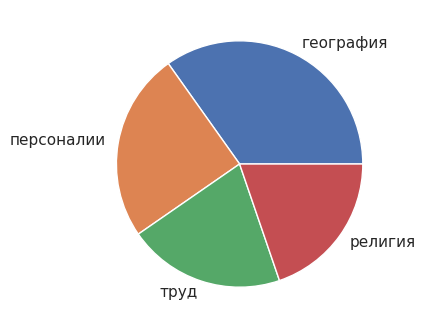

In [60]:
labels = dialectdata.tag.unique()
plt.pie(dialectdata.tag.value_counts(normalize=True), labels = labels)
plt.show()

Начнем подготовку данных для кластеризации

In [10]:
dialectdata['text_clean'] = dialectdata['text'].map(lambda x: x.lower())

In [11]:
dialectdata['text_clean'] = dialectdata['text_clean'].map(lambda x: word_tokenize(x))

In [14]:
for text in dialectdata['text_clean']:
  for elem in text:
    if elem.isalnum():
      continue
    else:
      text.remove(elem)

In [17]:
for text in dialectdata['text_clean']:
  for elem in text:
    if elem in russian_stopwords:
      text.remove(elem)
    else:
      continue

Векторизация текстовых данных

Поле text_clean

In [18]:
input_text = list(dialectdata.text_clean.values)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]

In [19]:
model = Doc2Vec(documents, vector_size=5, window=3, min_count=1, workers=4)

In [20]:
model.save("text_clean.model")

In [21]:
vectors = []
for x in documents:
    vec = list(model[x.tags][0])
    vectors.append(vec)

In [22]:
tc_vec = pd.DataFrame(vectors,
                        columns=['tc1', 'tc2', 'tc3','tc4','tc5'])

In [23]:
dialectdata = dialectdata.join(tc_vec, how='left')

In [24]:
dialectdata.head()

,text,tag,topic,text_clean,tc1,tc2,tc3,tc4,tc5
0,"Становая названа потому, что Пугачев проходил ...",география,Название Становая,"[становая, названа, пугачев, проходил, раненые...",0.378796,0.483187,0.363719,-0.172863,-0.280842
1,"Шарташ раньше называли Кержаками, потому что о...",география,"Прозвища: Кержаки, Кишочники и Кулажники","[шарташ, раньше, называли, кержаками, стакана,...",0.117879,0.465774,0.371351,-0.357066,-0.110989
2,"Маркова шахта так называется, потому что был т...",персоналии,Маркова шахта,"[маркова, шахта, называется, мужчина, марков, ...",0.518486,0.344281,0.115891,-0.108811,-0.162278
3,"А в гражданскую войну здесь драка была. Белые,...",персоналии,Гражданская война,"[гражданскую, войну, драка, белые, чехи, полуш...",0.246564,0.383574,0.210981,-0.476998,-0.263910
4,"Екатеринбург был уже, и здесь сначала село, а ...",география,Название улиц,"[екатеринбург, сначала, село, завод, берёзовск...",0.436520,0.418929,0.316760,-0.213040,0.103379


In [25]:
dd_final_clust = dialectdata[['tc1', 'tc2', 'tc3','tc4','tc5']]

Кластеризация

Подготовка данных

In [26]:
from sklearn import metrics

Нормируем значения параметров, чтобы они определялись на едином промежутке

In [27]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
data_scaled=dd_final_clust.copy()
data_scaled[data_scaled.columns]=std_scaler.fit_transform(data_scaled)

Метод главных компонент (PCA): в n-мерном датасете найдем две компоненты, вдоль которых существует наибольшая дисперсия данных

In [28]:
from sklearn.decomposition import PCA
pca_2 = PCA(2)
pca_2_result = pca_2.fit_transform(data_scaled)
pca_2_result.shape

(1048, 2)

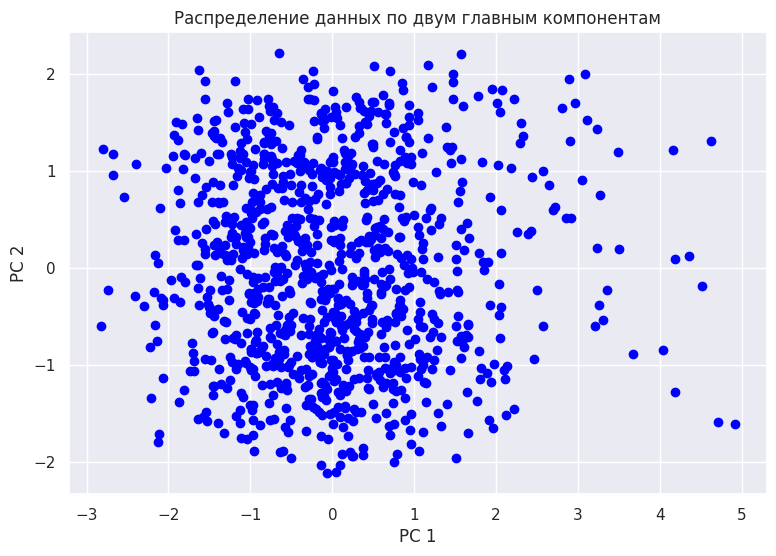

In [29]:
sns.set(rc={'figure.figsize':(9,6)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], color='blue')
plt.xlabel('PC 1')
plt.ylabel('PC 2')

plt.title('Распределение данных по двум главным компонентам')
plt.show()

Определение оптимального количества кластеров для k-means метода, который мог бы использоваться как бейзлайн, но в итоге оказался основным и единственным адекватным

In [30]:
from tqdm import tqdm

In [31]:
import sklearn.cluster as cluster

inertia = []
for i in tqdm(range(2,20)):

    kmeans = cluster.KMeans(
               n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17
    )


    kmeans.fit(pca_2_result)
    inertia.append(kmeans.inertia_)

100%|██████████| 18/18 [00:01<00:00,  9.83it/s]


In [32]:
from sklearn.metrics import silhouette_score

silhouette = {}
for i in tqdm(range(2,20)):
    kmeans = cluster.KMeans(n_clusters=i,
               init='k-means++',
               n_init=15,
               max_iter=500,
               random_state=17)
    kmeans.fit(pca_2_result)

    silhouette[i] = silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean')

100%|██████████| 18/18 [00:03<00:00,  5.14it/s]


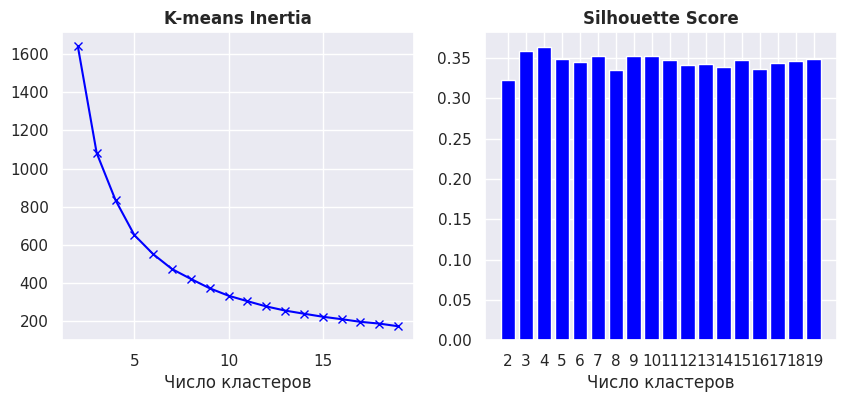

In [33]:
sns.set(font_scale=1, rc={'figure.figsize':(10,4)})

plt.subplot(1, 2, 1)

plt.plot(range(2,len(inertia)+2), inertia, marker='x',color='blue')

plt.xlabel('Число кластеров')
plt.title('K-means Inertia',fontweight='bold')
plt.grid(True)

plt.subplot(1, 2, 2)

plt.bar(range(len(silhouette)), list(silhouette.values()), align='center',color= 'blue')
plt.xticks(range(len(silhouette)), list(silhouette.keys()))
plt.grid(True)
plt.title('Silhouette Score',fontweight='bold')
plt.xlabel('Число кластеров')


plt.show()

In [34]:
kmeans = cluster.KMeans(n_clusters=4,random_state=17,init='k-means++')

kmeans_labels = kmeans.fit_predict(pca_2_result)

centroids = kmeans.cluster_centers_

display(pd.Series(kmeans_labels).value_counts())

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3    390
2    283
1    247
0    128
dtype: int64

In [35]:
data_scaled['Cluster']=kmeans_labels

pca_2_df = pd.DataFrame(pca_2_result)
pca_2_df['Cluster']=kmeans_labels

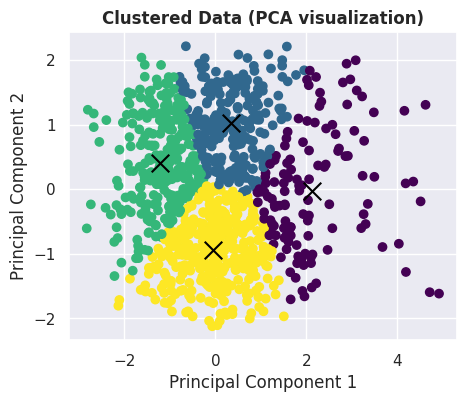

In [36]:
sns.set( rc={'figure.figsize':(5,4)},font_scale=1)

plt.scatter(x=pca_2_result[:, 0], y=pca_2_result[:, 1], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=160, color='black')

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.title('Clustered Data (PCA visualization)',fontweight='bold')

plt.show()

Посчитаем метрики

In [37]:
print("Inertia score: %0.1f" % kmeans.inertia_,
     "\nSilhouette score: %0.1f" % silhouette_score(pca_2_result, kmeans.labels_, metric='euclidean'))

Inertia score: 835.2 
Silhouette score: 0.4


Для сравнения DBSCAN

In [ ]:
from sklearn.cluster import  DBSCAN

from sklearn.datasets import make_blobs

In [ ]:
X = pca_2_result

In [ ]:
cluster = DBSCAN(min_samples=4, eps=0.5)

In [ ]:
cluster.fit(X)

DBSCAN(min_samples=4)

In [ ]:
data_scaled['Cluster'] = cluster.labels_
data_scaled['Cluster'].value_counts()

 2    994
-1     28
 3     13
 0      5
 1      4
 4      4
Name: Cluster, dtype: int64

In [ ]:
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X,cluster.labels_ ))

Silhouette Coefficient: 0.425


Зрительно сопоставим результаты кластеризации и ручной классификации

In [39]:
dd_classification = pd.DataFrame(dialectdata['text'])
dd_classification['cluster'] = data_scaled['Cluster']
dd_classification['tag'] = dialectdata['tag']
dd_classification.head(50)

,text,cluster,tag
0,"Становая названа потому, что Пугачев проходил ...",0,география
1,"Шарташ раньше называли Кержаками, потому что о...",0,география
2,"Маркова шахта так называется, потому что был т...",0,персоналии
3,"А в гражданскую войну здесь драка была. Белые,...",0,персоналии
4,"Екатеринбург был уже, и здесь сначала село, а ...",0,география
5,Один раз я машину видела. Здоровенную. Как сте...,0,труд
6,"Мне рассказывали, да и сама видела-в шахте вез...",0,труд
7,"Две шахты бывает. Одни-жильные, то есть каменн...",0,труд
8,Была контора шахты. Тут рудник над всеми шахта...,0,труд
9,Работали целый день с семи до шести вечера. Ра...,0,труд


Или вот так:

In [63]:
dd_1 = dd_classification.query("""cluster == 0""")
dd_1.head(15)

,text,cluster,tag
0,"Становая названа потому, что Пугачев проходил ...",0,география
1,"Шарташ раньше называли Кержаками, потому что о...",0,география
2,"Маркова шахта так называется, потому что был т...",0,персоналии
3,"А в гражданскую войну здесь драка была. Белые,...",0,персоналии
4,"Екатеринбург был уже, и здесь сначала село, а ...",0,география
5,Один раз я машину видела. Здоровенную. Как сте...,0,труд
6,"Мне рассказывали, да и сама видела-в шахте вез...",0,труд
7,"Две шахты бывает. Одни-жильные, то есть каменн...",0,труд
8,Была контора шахты. Тут рудник над всеми шахта...,0,труд
9,Работали целый день с семи до шести вечера. Ра...,0,труд


In [64]:
dd_2 = dd_classification.query("""cluster == 1""")
dd_2.head(15)

,text,cluster,tag
10,"В этом месте кругом шахты; в лесу есть ямы, та...",1,труд
19,"Идем мы с товарищем, взяли бутылочку. Спросили...",1,труд
22,"В школу меня не стали отдавать. Говорили, что ...",1,география
27,"Тогда время не указан было, работали с утра до...",1,труд
33,"Здесь когда золото начиналось, с 1747г здесь н...",1,труд
40,Много золото мыли на поверхности. Оно было рас...,1,труд
42,Уехали мы торфяник однажды и спрятались там в ...,1,персоналии
44,Мы мыли золото с тятей. Я машину качала. Снача...,1,труд
48,Первое золото в России нашел шарташский житель...,1,персоналии
60,"Жил у нас по Новой улице Воротников, коммунист...",1,персоналии


In [65]:
dd_3 = dd_classification.query("""cluster == 2""")
dd_3.head(15)

,text,cluster,tag
57,Раньше как золото добывали? Копали совсем на п...,2,труд
88,"Дворы, в которых была одна корова лошадь, птиц...",2,труд
149,Симонов был очень богат. Однажды он попросил А...,2,персоналии
152,"Штейгер-было самое влиятельное лицо, он руково...",2,персоналии
156,"Пышминцы-кулачники. Смолу гнали, бондари хорош...",2,труд
158,"Мать моя, Елизавета Митрофановна была подпольщ...",2,персоналии
180,"Где от Урала мост, там пруд был. И по праву ст...",2,география
191,"Работала у нас девушка, я через нее и пострада...",2,труд
193,"В мае 1918г была здесь массовка, большевики хо...",2,персоналии
195,"У нас здесь в центре церковь была, так она уж ...",2,география


In [66]:
dd_4 = dd_classification.query("""cluster == 3""")
dd_4.head(15)

,text,cluster,tag
28,В няньках жила после школы. При мне трое родил...,3,труд
34,"Мама рассказывала, здесь она родилась, дядюшка...",3,труд
35,"Отец мой старатель был, здешний, урожденец. Он...",3,труд
37,"А не было у нас такого, чтобы отец много зараб...",3,труд
46,"Когда революция началась, народ обрадовался, н...",3,персоналии
56,В войну в нашей шахте женщины в забоях работал...,3,труд
59,"Про Ермака люди сказывали, часто сказывали, а ...",3,персоналии
61,"Была у нас Низменна шахта, людей туда сбрасыва...",3,труд
64,"Старики говорили, что во время революции в Ком...",3,персоналии
70,"В нашей улице хозяйничали ""партизаны"": это ста...",3,труд


Второй задачей было узнать, какие слова модель посчитает ключевой по итогам кластеризации. Для этого построим линейную модель и изучим, что есть у нее внутри.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [41]:
final_vectorizer = TfidfVectorizer(lowercase=True, stop_words=russian_stopwords)

In [42]:
log_model = LogisticRegression()

In [43]:
final_pipeline = Pipeline(steps=[('vectorizer', final_vectorizer), ('model', log_model)])

In [44]:
X = [' '.join(map(str, l)) for l in dialectdata['text_clean']]
y = dd_classification['cluster']

In [45]:
from sklearn.pipeline import Pipeline

In [46]:
final_pipeline.fit(X, y)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(stop_words=['и', 'в', 'во', 'не', 'что', 'он',
                                             'на', 'я', 'с', 'со', 'как', 'а',
                                             'то', 'все', 'она', 'так', 'его',
                                             'но', 'да', 'ты', 'к', 'у', 'же',
                                             'вы', 'за', 'бы', 'по', 'только',
                                             'ее', 'мне', ...])),
                ('model', LogisticRegression())])

In [47]:
lin_model_coef = final_pipeline.get_params()['model'].coef_[0]
lin_model_coef

array([ 0.01310007,  0.02627071, -0.01939323, ..., -0.0426707 ,
       -0.01173071, -0.00951784])

In [48]:
tfidfmapping = final_pipeline.get_params()['vectorizer'].vocabulary_

In [49]:
tfidf_map=[(x,tfidfmapping[x]) for x in tfidfmapping]
tfidf_map[:10]

[('становая', 9328),
 ('названа', 4937),
 ('пугачев', 7730),
 ('проходил', 7683),
 ('раненые', 8002),
 ('больные', 583),
 ('долго', 2171),
 ('стояли', 9473),
 ('шарташ', 10826),
 ('раньше', 8011)]

In [50]:
tfidf_map.sort(key=lambda x: x[1])

In [51]:
vocab_tfidf = [x[0] for x in tfidf_map]
vocab_tfidf = np.array(vocab_tfidf)
vocab_tfidf

array(['10', '100', '1000', ..., 'ёлочка', 'ём', 'ёрзали'], dtype='<U20')

In [52]:
coef_df = pd.DataFrame(zip(vocab_tfidf, lin_model_coef), columns=['word', 'coef'])

In [70]:
coef_df.sort_values(by='coef', ascending=False).head(100)

,word,coef
3063,золото,0.943487
10842,шахту,0.893674
10837,шахте,0.841057
418,березовский,0.831566
5533,образовался,0.746723
...,...,...
5129,находил,0.309211
9656,тагила,0.308076
5007,нами,0.306416
6394,пленные,0.306336
